<a href="https://colab.research.google.com/github/khakhiD/ML/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

import os

In [19]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == 'with_mask':
        return 1
    elif obj.find('name').text == 'mask_weared_incorrect':
        return 2
    return 0

def generate_target(image_id, file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        
        num_objs = len(objects)
        
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [8]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"khakhid","key":"47c5de2314f1541c4b46bf27f934afad"}'}

In [10]:
ls -1ha kaggle.json

kaggle.json


In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d andrewmvd/face-mask-detection

face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
!ls

 drive			  'kaggle (1).json'   kaggle.json
 face-mask-detection.zip  'kaggle (2).json'   sample_data


In [18]:
!unzip /content/face-mask-detection.zip

Archive:  /content/face-mask-detection.zip
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
imgs = list(sorted(os.listdir("/content/drive/MyDrive/Colab Notebooks/face-mask-detection/images/")))
labels = list(sorted(os.listdir("/content/drive/MyDrive/Colab Notebooks/face-mask-detection/annotations/")))

In [9]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them too 이미지 파일 다 불러와서 정렬
        # ensure that they are aligned 정렬됐는지 확인
        self.imgs = list(sorted(os.listdir("/content/drive/MyDrive/Colab Notebooks/face-mask-detection/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/face-mask-detection/images/", file_image)
        label_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/face-mask-detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB") #BGR 사진을 RGB로 변경하기
        #Generate Label        라벨 생성
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
    ]) #ToTensor() - 데이터를 tensor로 바꿔준다. https://wikidocs.net/157285

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))
dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [13]:
torch.cuda.is_available()

True

In [14]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [17]:
#Downloading:
#"https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
# to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
model = get_model_instance_segmentation(3)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [22]:
# Train Model
num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(86.1549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61.5217, device='cuda:0', grad_fn=<AddBackward0>)
tensor(48.3184, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.7371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.8040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.8991, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.1436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.5637, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.3548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.2626, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.6681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.0489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.3212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.9832, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.3192, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.6303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.7668, device='cuda:0'

In [24]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [25]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[184.3963, 100.5598, 226.8540, 144.3602],
          [321.1229,  92.9683, 359.1706, 141.9732]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 2], device='cuda:0'),
  'scores': tensor([0.9973, 0.0568], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 20.8375,  72.8093,  42.1878,  94.0443],
          [224.7705,  35.9579, 257.9628,  76.3380],
          [319.4587,  33.2142, 351.5923,  71.6000],
          [143.5195,  72.9361, 172.4517, 114.4918],
          [298.7391,  59.0792, 312.8836,  80.3377],
          [192.0907,  66.7457, 214.9459,  94.5498],
          [367.4879,  70.6762, 392.1494,  97.6532],
          [367.8783,  71.2153, 389.5656, 100.5559],
          [ 78.3219,  55.7528, 110.3322,  87.1204],
          [144.0061,  73.1024, 171.9035, 109.7769]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9963, 0.9935, 0.9917, 0.9839, 0.

Function to plot Image

In [78]:
def plot_image(img_tensor, annotation, block=True):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = img.astype(np.uint8).copy()

    # Display the image
    ax.imshow(img)
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        rect = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=1)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


TypeError: ignored

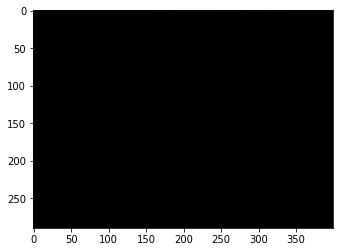

In [79]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])